# Convolutional Autoencoders for Image Denoising

## Loading and data preprocessing

### Loading Necessary Libraries 

In [ ]:
import os
import time
import ymno3_custom_dataset
%reload_ext ymno3_custom_dataset
import tensorflow as tf
#from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from PIL import Image
from glob import glob

from tensorflow.keras import datasets, layers, models, callbacks, metrics, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from tensorflow.keras import backend

In [2]:
# Mostly for memory reasons
tf.keras.backend.clear_session()

### Initial Parameters for training

In [ ]:
batch_size = 8
epoches = 8
latent_dim = 64
lr = 0.0001
std_noise = 0.4
image_size = 512
train_size = 0.7

### Define paths and directories

In [3]:

# to save some parameters of the model in final output
name = f"latent_dim_RMSG_lr_{lr}_bs_{batch_size}_ep_{epoches}_ld_{latent_dim}_noise_{std_noise}"

# Define directories to read and save images, as I use two different directories for reading and saving.
folder_path = os.getcwd()

folder_source = os.path.join(folder_path, "noisy images new")
folder_dest = os.path.join(folder_path, "noisy images new dataset")

save_folder = os.path.join(os.getcwd(), "created images new")

# Create train and test directories
os.makedirs(os.path.join(folder_dest, "train_set"), exist_ok = True)
os.makedirs(os.path.join(folder_dest, "test_set"), exist_ok = True)

### Load images

In [ ]:
ymno3_custom_dataset.custom_dataset(folder_source, folder_dest, image_size, train_size, std_noise)

In [4]:
# Load the preprocessed datasets
x_train = np.load(os.path.join(folder_dest, "x_train.npy"))
x_test = np.load(os.path.join(folder_dest, "x_test.npy"))
x_train_noisy = np.load(os.path.join(folder_dest, "x_train_noisy.npy"))
x_test_noisy = np.load(os.path.join(folder_dest, "x_test_noisy.npy"))

In [6]:
datagen = image.ImageDataGenerator(rotation_range=15)
train_generator = datagen.flow(x_train_noisy, x_train, batch_size=batch_size, shuffle=True)
valid_generator = datagen.flow(x_test_noisy, x_test, batch_size=batch_size, shuffle=False)

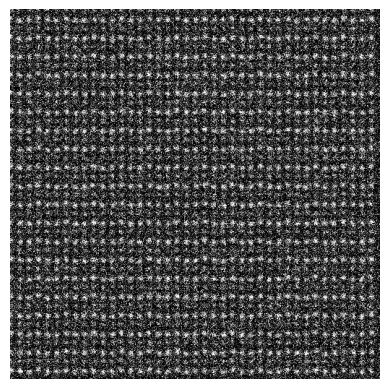

In [8]:
# Visualizing only one image from a batch
sample_noisy_img = x_train_noisy[:2]

# Plot the noisy image
plt.imshow(sample_noisy_img[0, :, :, 0]*255., cmap='gray')
plt.axis('off')
plt.show()

## Defining the CNN Autoencoder Model

In [ ]:
class encoder(models.Model):
    def __init__(self, latent_dim):
        super(encoder, self).__init__()
        
        self.latent_dim = latent_dim
            
        self.conv1 = layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same",
                       name="encode_conv1")
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.LeakyReLU()

        self.conv2 = layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same",  name="encode_conv2")
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.LeakyReLU()

        self.conv3 = layers.Conv2D(filters=256, kernel_size=(3,3), strides=2, padding="same",  name="encode_conv3")
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.LeakyReLU()

        self.conv4 = layers.Conv2D(filters=512, kernel_size=(3,3), strides=2, padding="same",  name="encode_conv4")
        self.bn4 = layers.BatchNormalization()
        self.act4 = layers.LeakyReLU()
        
        self.conv5 = layers.Conv2D(filters=512, kernel_size=(3,3), strides=2, padding="same", name="encode_conv5")
        self.bn5 = layers.BatchNormalization()
        self.act5 = layers.LeakyReLU()

        self.flat = layers.Flatten()
        self.dense = layers.Dense(self.latent_dim)
              
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.act5(x)

        self.shape = backend.int_shape(x)
        
        x = self.flat(x)
        x = self.dense(x)
        
        return x, self.shape
    
class decoder(models.Model):
    def __init__(self, conv_shape, latent_dim):
        super(decoder, self).__init__()
        
        self.conv_shape = conv_shape
        self.latent_dim = latent_dim
        
        self.dense = layers.Dense(units=self.conv_shape[1]*self.conv_shape[2]*self.conv_shape[3],
                                   name="decode_dense1")
        self.bn0 = layers.BatchNormalization()
        self.act0 = layers.LeakyReLU()
        
        self.conv1_t = layers.Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding="same", 
                              name = "decode_conv2d_1")
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.LeakyReLU()

        self.conv2_t = layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding="same", 
                              name = "decode_conv2d_2")
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.LeakyReLU()

        self.conv3_t = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding="same", 
                              name = "decode_conv2d_3")
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.LeakyReLU()

        self.conv4_t = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same", 
                              name = "decode_conv2d_4")
        self.bn4 = layers.BatchNormalization()
        self.act4 = layers.LeakyReLU()
        
        self.conv5_t = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same", 
                              name = "decode_conv2d_5")
        self.bn5 = layers.BatchNormalization()
        self.act5 = layers.LeakyReLU()
        
        self.conv6_t = layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(1,1), padding="same", 
                             activation="sigmoid", name="decode_conv2d_6")
        
        
    def call(self, latent_inputs):
        x=self.dense(latent_inputs)
        x=self.bn0(x)
        x=self.act0(x)
      
        x = tf.reshape(x, shape=[-1, self.conv_shape[1], self.conv_shape[2], self.conv_shape[3]], name="decoder_reshape")
        
        x = self.conv1_t(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2_t(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.conv3_t(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.conv4_t(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.conv5_t(x)
        x = self.bn5(x)
        x = self.act5(x)
        x = self.conv6_t(x)
        return x

class encoder_decoder(models.Model):
    def __init__(self, encoder, decoder):
        super(encoder_decoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, x):
        encoded, _ = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

    
class Loss_Print(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        """
        logs is a dictionary containing information about the training/validation metrics at the end of each epoch. 
        This dictionary is automatically provided by Keras to the callback during training.
        """
        print(f"Epoch {epoch + 1}/{epoches}, Loss: {logs['loss'].numpy()}, Val Loss: {logs['val_loss'].numpy()}")


def create_model(latent_dim):  
    """
    Combine encoder and decoder to create the encoder_decoder model
    Input: encoder and decoder models
    output: Autoencoder model
    """
    
    enc = encoder(latent_dim)
    encoded,conv_shape = enc(x_train[:1])
    
    dec = decoder(conv_shape, latent_dim)

    model = encoder_decoder(encoder = enc, decoder = dec)
    return model

def train(loss_fn, model, optimizer, lr, latent_dim, epoches = epoches, batches = batch_size):
    """
    model: the output of autoencoder by combining enocder and decoder
    lr: Learning rate
    """
    Loss_Print_callback = Loss_Print()
    
    #Training loop
    training_loss = []
    validation_loss = []
    
    #calculate the average loss for both sets using the number of batches in each set.
    num_train_batches = len(x_train_noisy) // batch_size
    num_val_batches = len(x_test_noisy) // batch_size
    
    num_train_samples = len(x_train_noisy)
    num_val_samples = len(x_test_noisy)
    
    for epoch in range(epoches):
        epoch_train_loss = 0
               
        #Training the model
        for batch_number in range(num_train_batches):
            noisy_batch, clean_batch = train_generator.next()
            with tf.GradientTape() as tape:
                #forward pass
                predictions = model(noisy_batch, training = True)
                #Calculate the loss
                loss_value = tf.keras.losses.mean_absolute_error(clean_batch, predictions)
                #epoch_loss+=loss_value
                epoch_train_loss += tf.reduce_mean(loss_value)
                
            #calculate gradients and update weights
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # Calculate average loss for the epoch
        average_loss = epoch_train_loss/num_train_batches
        training_loss.append(average_loss.numpy())
        
        #validation of the test data
        epoch_val_loss = 0
        
        for batch_number in range(num_val_batches):
            noisy_batch, clean_batch = valid_generator.next()
            predictions = model(noisy_batch, training = False)
            #Calculate the loss
            epoch_val_loss += tf.keras.losses.mean_absolute_error(clean_batch, predictions)
            
        # Calculate average validation loss
        epoch_val_loss = epoch_val_loss/num_val_samples

        # Print progress using the custom callback
        Loss_Print_callback.on_epoch_end(epoch, {'loss': average_loss, 'val_loss': tf.reduce_mean(epoch_val_loss)})
        validation_loss.append(tf.reduce_mean(epoch_val_loss).numpy())
        
    # Save the entire model (architecture, optimizer, weights)
    model_save_path = os.path.join(save_folder, name+"_autoencoder_model")
    model.save(model_save_path, save_format="tf")
    print("Model saved successfully!")
    return training_loss, validation_loss

# Call the train function
start = time.time()
#optimizer = tf.keras.optimizers.Adam(lr)
optimizer = tf.keras.optimizers.RMSprop(lr)

# Combine encoder and decoder to create the encoder_decoder model
loss_fn = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
auto_encoder = create_model(latent_dim)
auto_encoder.compile(optimizer=optimizer, loss=loss_fn)


training_loss, validation_loss = train(loss_fn, auto_encoder, optimizer, lr,latent_dim,  epoches = epoches , batches = batch_size)
finish = time.time()
print("total time in minute is: ", (finish - start)/60)

weights_save_path = os.path.join(save_folder, name+"_auto_encoder_weights")
auto_encoder.save_weights(weights_save_path)

### Metrics

In [ ]:
ax1 = plt.subplot()
plot1, = ax1.plot(range(1, epoches+1), training_loss, marker = "*", color = "red", label = "training_loss")
ax2 = ax1.twinx()
plot2, = ax2.plot(range(1, epoches+1), validation_loss, marker = "o", label = "validation_loss")

plt.xlabel('epoch')
plt.legend([plot1, plot2],["training_loss", "validation_loss"])
plt.savefig(os.path.join(save_folder, name+"losses.png"))
plt.show();

### Visualization

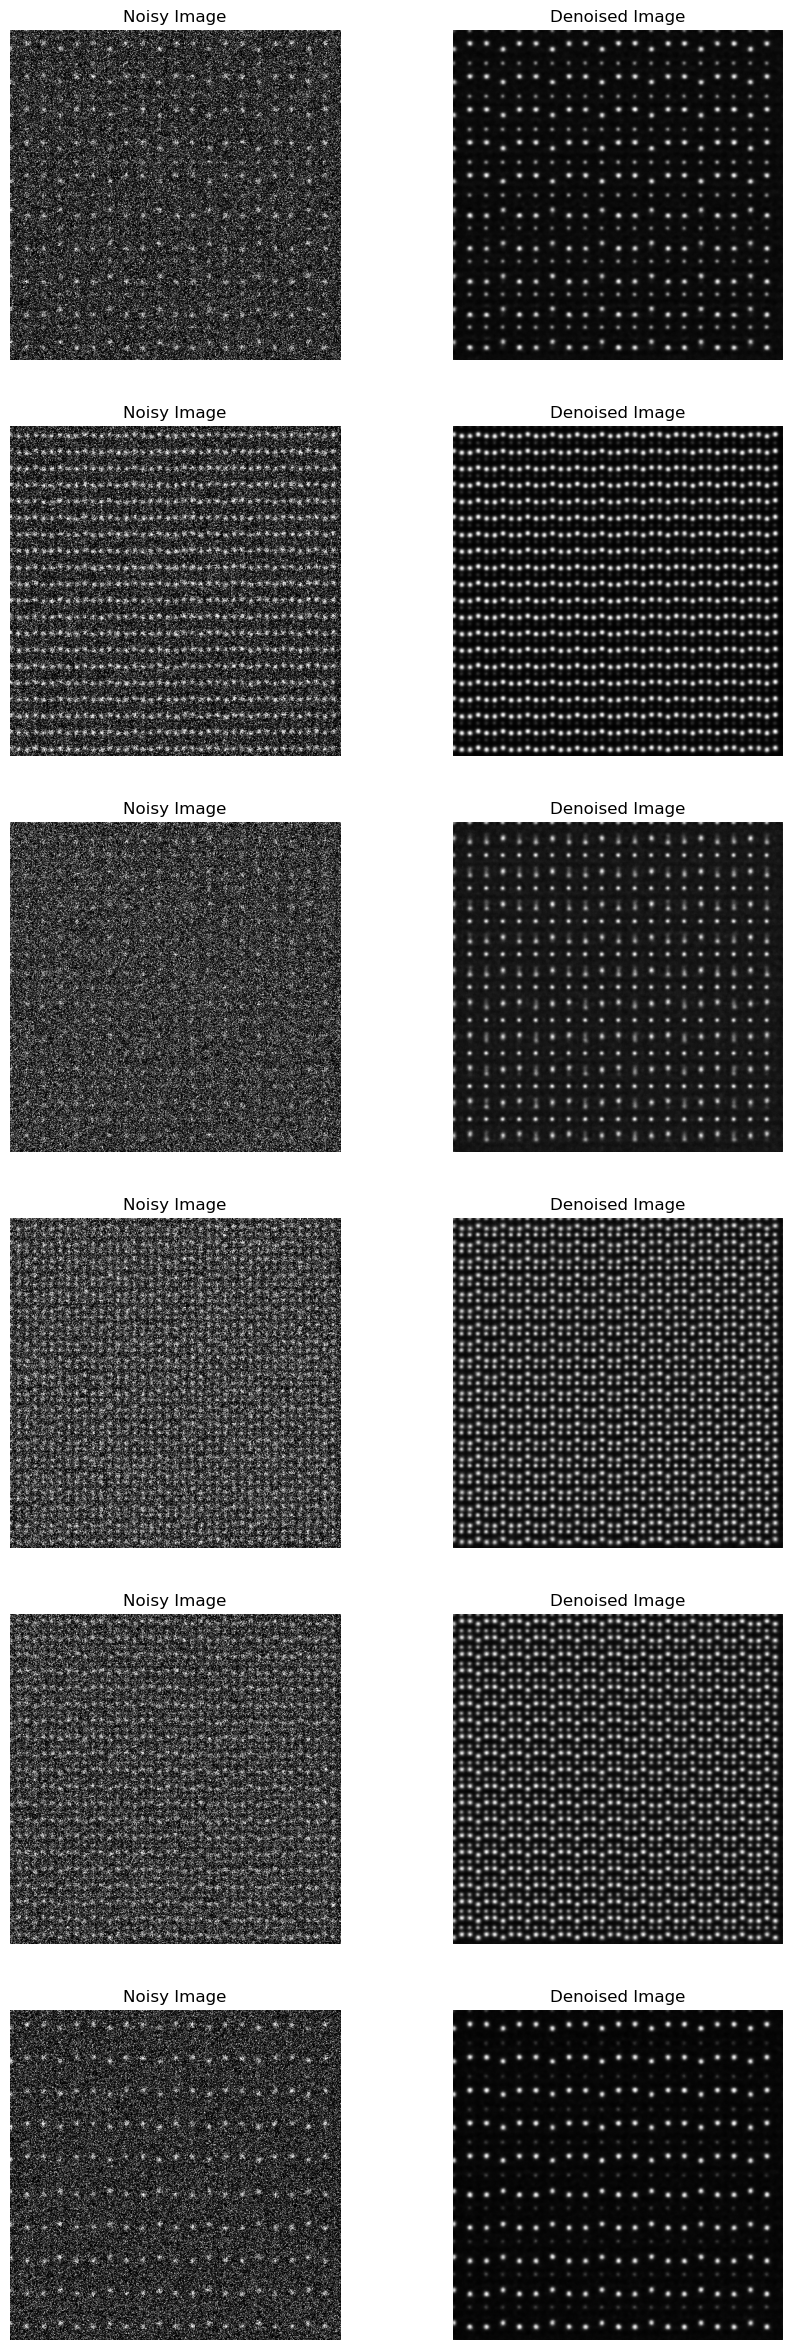

In [12]:
model = tf.keras.models.load_model(save_folder+"/"+name+"_autoencoder_model")

# Get denoised images using the trained model
num_images = 6
n_rows = 6
n_col = 2

indices = np.random.choice(len(x_test_noisy), num_images)
denoised_test_images = model.predict(x_test_noisy[indices])
denoised_test_images = np.clip(denoised_test_images, 0, 1)

# Specify the relative widths of the subplot columns
width_ratios = [1.2, 1]

# Create the subplots with adjusted relative widths
fig, axes = plt.subplots(n_rows, n_col, figsize=(20, 30), gridspec_kw={'width_ratios': width_ratios})

for i in range(num_images):
    
    plt.subplot(n_rows, n_col, i*n_col+1)
    plt.imshow(x_test_noisy[indices[i]].reshape(image_size, image_size), cmap = "gray")
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(n_rows, n_col, i*n_col+2)
    plt.imshow(denoised_test_images[i,:,:, 0], cmap = "gray")
    plt.title("Denoised Image")
    plt.axis("off")

plt.subplots_adjust(wspace = -0.6)
plt.savefig(os.path.join(save_folder, name+"noisy and denoised images 3d batch.png"), bbox_inches='tight')
plt.show();  